In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import linear_model

In [23]:
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import normalize as l2_normalize
from time import *

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import orthogonal_mp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import random
import pickle

from PIL import Image
import imageio

In [25]:
patch_size = (8, 8)
patch_vector_len = patch_size[0]*patch_size[1]
n_components = 441

In [76]:
def noise_level(mu, sigma, img):
    img = arr / 255
    noise = np.random.normal(mu, sigma, img.shape)
    gaussian_out = img + noise
    gaussian_out = np.clip(gaussian_out, 0, 1)
    gaussian_out = np.uint8(gaussian_out*255)
    
    return gaussian_out

img = Image.open("/Users/a080528/Downloads/Dog.png").convert("L")
gray = plt.imread('/Users/a080528/Downloads/Dog.png')
arr = np.asarray(img)
dog = arr
blur_lucky_10 = noise_level(0,0.1,arr)
blur_lucky_50 = noise_level(0,0.3,arr)
blur_lucky_80 = noise_level(0,0.5,arr)

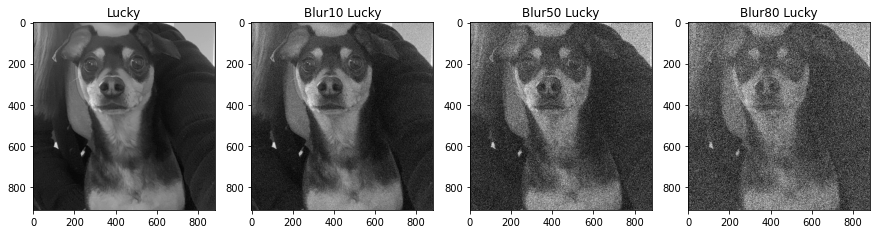

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.title('Lucky')

plt.subplot(1,4,2)
plt.imshow(blur_lucky_10, cmap='gray', vmin=0, vmax=255)
plt.title('Blur10 Lucky')

plt.subplot(1,4,3)
plt.imshow(blur_lucky_50, cmap='gray', vmin=0, vmax=255)
plt.title('Blur50 Lucky')

plt.subplot(1,4,4)
plt.imshow(blur_lucky_80, cmap='gray', vmin=0, vmax=255)
plt.title('Blur80 Lucky')
plt.show()

In [180]:
face = imageio.imread('/Users/a080528/Downloads/Project/original.jpg')
face = face / 255.0
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]

In [189]:
dog = arr
#dog = face
height, width = dog.shape

# Distort the image
print("Distorting image...")


#distorted += 0.075 * np.random.randn(height, width)
miss_pixel = [20, 40, 60, 70]
distorted_dataset = {}
for i in miss_pixel:
    distorted = dog.copy()
    for _ in range(int(np.floor(height*width*(i/100)))):
         distorted[random.randint(0, height - 1), random.randint(0, width - 1)] = 0
    distorted_dataset[str(i)+'%'] = distorted

Distorting image...


In [190]:
def ksvd_bp(Data, num_atoms, max_iter, tol, approx = False,prior_D = None):
    # **implemented using column major order**
    Data = Data.T
    
    # intialization
    if prior_D is not None: 
        D = prior_D / np.linalg.norm(prior_D, axis=0)
        Y = Data
        X = np.zeros([num_atoms, Data.shape[1]])
    else:
        # randomly select initial dictionary from data
        idx_set = range(Data.shape[1])
        select_idxs = np.random.choice(idx_set, num_atoms, replace=False) 
        
        Y = Data[:,np.delete(idx_set, select_idxs)]
        X = np.zeros([num_atoms, Data.shape[1] - num_atoms])
        D = Data[:,select_idxs] / np.linalg.norm(Data[:,select_idxs], axis=0)
        
    ##### L1 regression on image #####
    md = linear_model.Lasso(alpha=1)
    md.fit(D*256,Y)
    x = md.coef_.T
    step_size = 0.3
    
    ##### L1 regression on image #####
    
    for _ in range(max_iter):
        for i in range(D.shape[1]):
            index = np.nonzero(x[i,:])[0]
            if len(index) == 0:
                continue
            if approx:
                E = (Y[:,index] - D@x[:,index])
                D = (E @ x[0,index])
            else:
                
                #### Gradient descent ##### 
                grad = (((D@x-Y)@x.T)*step_size)/256
                D = (D - grad*step_size)
                if(np.linalg.norm(grad*step_size-D) < 5000):
                    grad *= 1000

            break
                
        e = np.linalg.norm(abs(D@x) - Y)
        if(e < tol):
            break
    return(D,Y,x)

def psnr(reconstruct, original):
    return (10 * np.log10(255*255/(np.sum(np.square(reconstruct-(original)))/(original.shape[0]*original.shape[1]))))

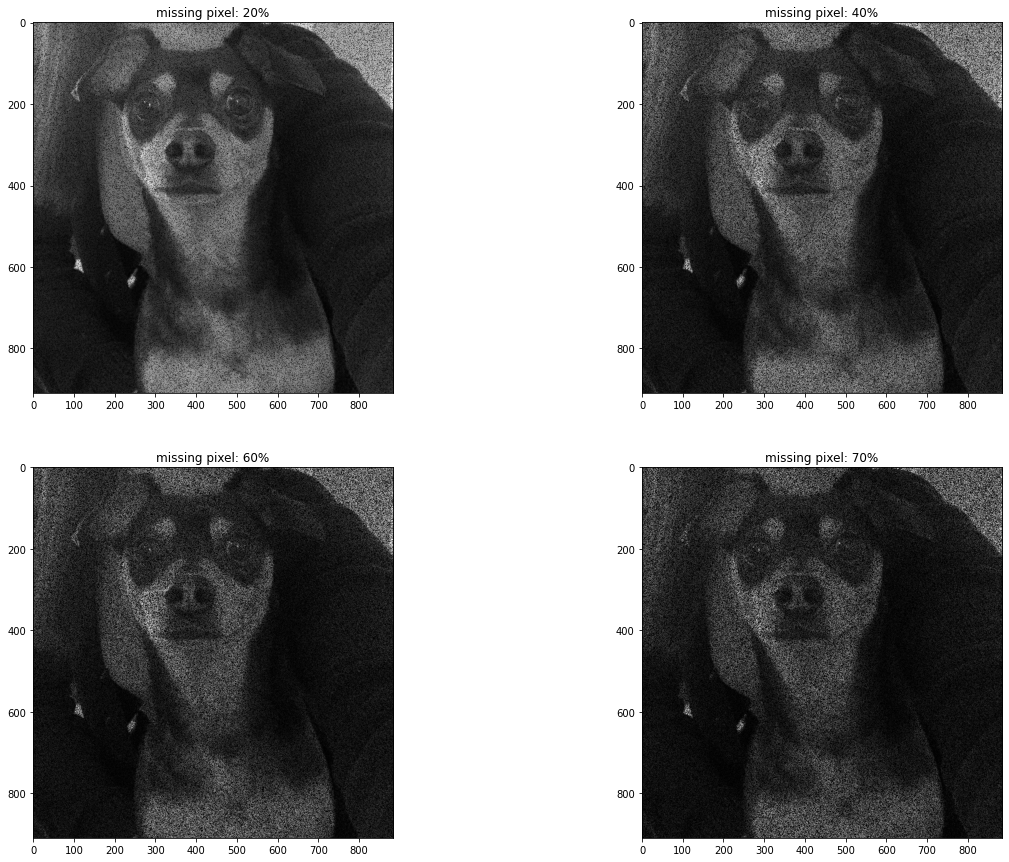

In [192]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title('missing pixel: 20%')
plt.imshow(distorted_dataset['20%'], cmap='gray')
plt.subplot(2,2,2)
plt.title('missing pixel: 40%')
plt.imshow(distorted_dataset['40%'], cmap='gray')
plt.subplot(2,2,3)
plt.title('missing pixel: 60%')
plt.imshow(distorted_dataset['60%'], cmap='gray')
plt.subplot(2,2,4)
plt.title('missing pixel: 70%')
plt.imshow(distorted_dataset['70%'], cmap='gray')

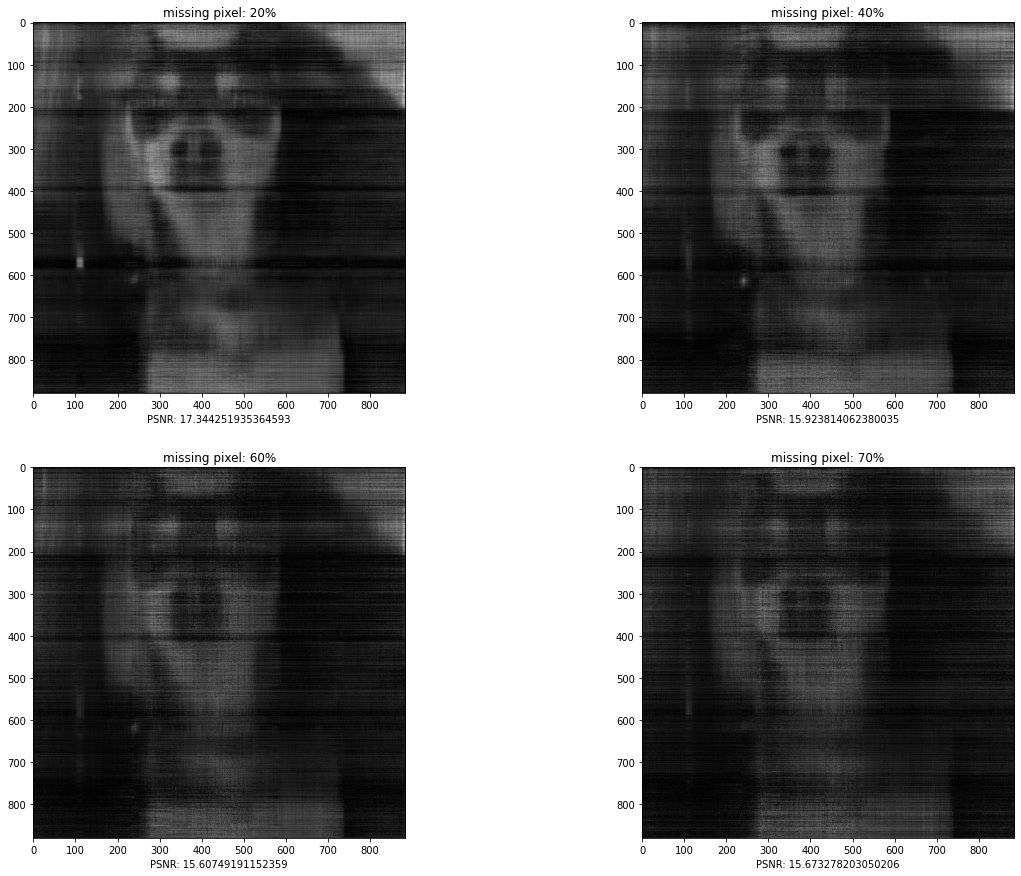

In [193]:
col = ['20%','40%','60%','70%']
plt.figure(figsize=(20,15))
reconstruct = {}
for i in range(len(col)):
    D,y,x = ksvd_bp(distorted_dataset[col[i]], 30,1000,1e-2)
    PSNR = psnr(abs(D@x).T, y.T)
    plt.subplot(2,2,i+1)
    plt.title('missing pixel: '+col[i])
    plt.imshow(abs(D@x).T, cmap='gray')
    plt.xlabel('PSNR: '+str(PSNR))
    reconstruct[col[i]] = abs(D@x).T
plt.show()

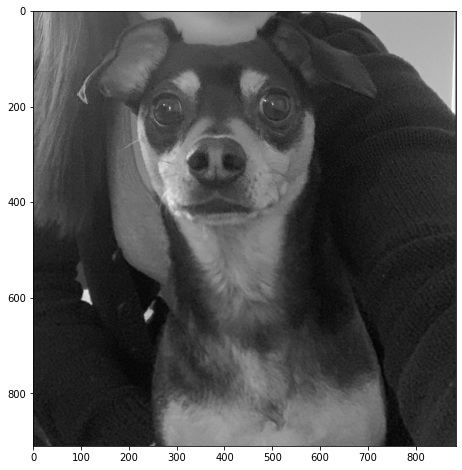

In [187]:
plt.figure(figsize=(15,8))
plt.imshow(arr/256,cmap='gray')
plt.show()

In [ ]:
plt.

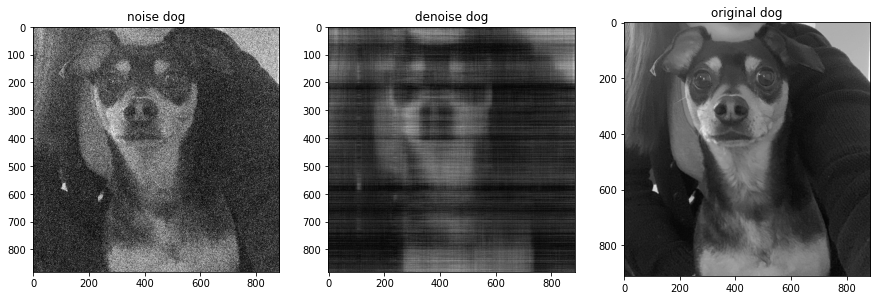

In [80]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.title('noise dog')
plt.imshow(y.T/256,cmap='gray')

plt.subplot(1,3,2)
plt.title('denoise dog')
plt.imshow((abs(D@x)).T,cmap='gray')

plt.subplot(1,3,3)
plt.title('original dog')
plt.imshow(arr/256,cmap='gray')
plt.show()

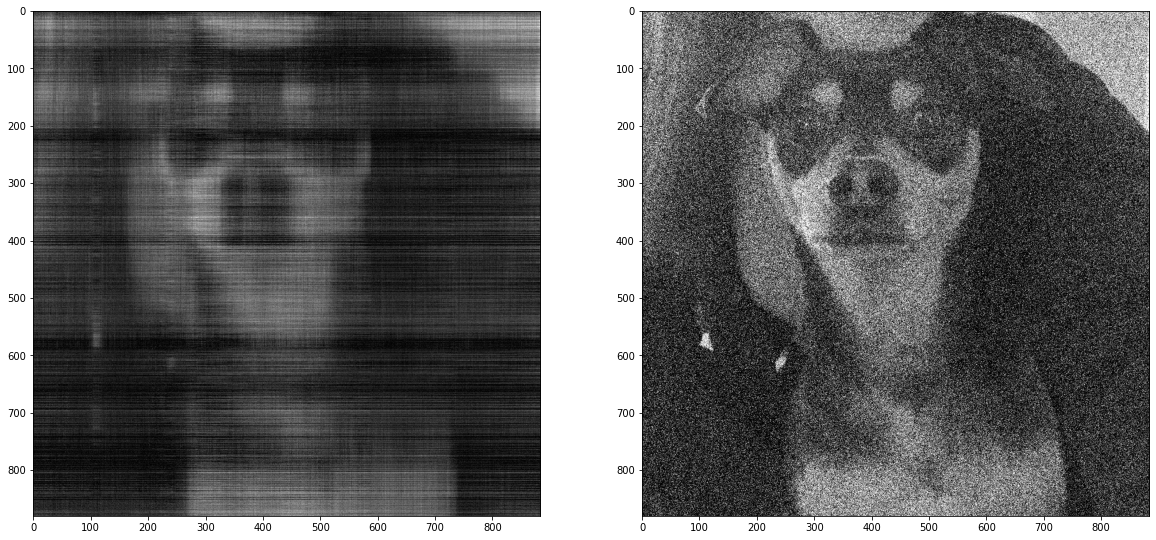

In [81]:
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
plt.imshow(abs(D@x).T,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y.T,cmap='gray')
plt.show()

Extracting reference patches...
done in 0.00s.
Training Signal/ Patch sizes (7811, 64)


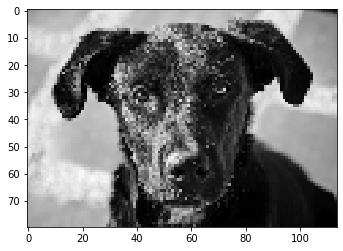

In [27]:
trainer = Image.open("/Users/a080528/Downloads/train.jpg").convert("L")
trainer = np.asarray(trainer)

trainer = trainer / 255.0
DownSampleCount = 8
trainer = trainer[::DownSampleCount, ::DownSampleCount] + trainer[1::DownSampleCount, ::DownSampleCount] + trainer[::DownSampleCount, 1::DownSampleCount] + trainer[1::DownSampleCount, 1::DownSampleCount]
trainer /= 4.0

#Extract patches from the training image
print("Extracting reference patches...")
t0 = time()
train_data = extract_patches_2d(trainer[:, :], patch_size)
train_data = train_data.reshape(train_data.shape[0], -1)
train_data -= np.mean(train_data, axis=0)
train_data /= np.std(train_data, axis=0)
print("done in %.2fs." % (time() - t0))
print("Training Signal/ Patch sizes",train_data.shape)
plt.imshow(trainer, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")

In [65]:
train_data.shape

(7811, 64)

In [57]:
height, width = trainer.shape

In [59]:
height,width

(80, 114)

In [68]:
result = D@x
patches = result.T
patches = patches.reshape(len(train_data)-30, *patch_size)
removed_noise_image = reconstruct_from_patches_2d(patches, (height, width))

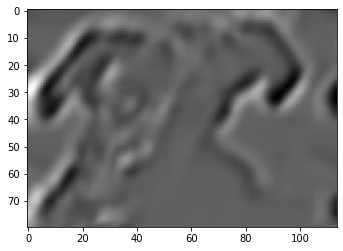

In [69]:
plt.imshow(removed_noise_image,cmap='gray')

In [46]:
(D@x).shape

(64, 7781)

In [67]:
D,y,x = ksvd_bp(train_data, 30,200,1e-2)

705.6034984692516
705.6033450278323
705.6031745088219
705.6029653517086
705.6027176999861
705.6023815235552
705.6019659133868
705.6014776966432
705.6009054498437
705.6002337317984
705.599433450191
705.5984628252457
705.597296586203
705.5960045596414
705.5946501945343
705.5932760482169
705.5918723286585
705.5904673681806
705.5890494893424
705.587621855064
705.5861801051998
705.5847200416065
705.5832390786976
705.581749846933
705.5802419763706
705.578726258927
705.5772033177934
705.5756771192567
705.5741474800335
705.5726123474738
705.571070817345
705.5695291632371
705.5679935314412
705.5664529451301
705.5649056964661
705.5633512691084
705.5617984402606
705.5602413714741
705.5586755017981
705.5571027069219
705.5555347766677
705.5539682304278
705.552403464771
705.5508411206162
705.5492827091505
705.5477268678691
705.5461729110692
705.5446194248923
705.5430686663841
705.5415241502203
705.539983952494
705.538446876972
705.536911781198
705.5353791807697
705.5338487604944
705.5323220054141
70

# Part two

In [554]:
def ksvd_bp(Data, num_atoms, max_iter, tol, approx = False,prior_D = None):
    # **implemented using column major order**
    Data = Data.T
    
    # intialization
    if prior_D is not None: 
        D = prior_D / np.linalg.norm(prior_D, axis=0)
        Y = Data
        X = np.zeros([num_atoms, Data.shape[1]])
    else:
        # randomly select initial dictionary from data
        idx_set = range(Data.shape[1])
        select_idxs = np.random.choice(idx_set, num_atoms, replace=False) 
        
        Y = Data[:,np.delete(idx_set, select_idxs)]
        X = np.zeros([num_atoms, Data.shape[1] - num_atoms])
        D = Data[:,select_idxs] / np.linalg.norm(Data[:,select_idxs], axis=0)
        
    
    md = linear_model.Lasso(alpha=1)
    md.fit(D*256,Y)
    x = md.coef_.T
    step_size = 0.3
    for _ in range(max_iter):
        for i in range(D.shape[1]):
            index = np.nonzero(x[i,:])[0]
            if len(index) == 0:
                continue
            if approx:
                E = (Y[:,index] - D@x[:,index])
                D = (E @ x[0,index])
            else:
                grad = (((D@x-Y)@x.T)*step_size)/256
                D = (D - grad*step_size)
                if(np.linalg.norm(grad*step_size-D) < 5000):
                    grad *= 1000

            break
                
        e = np.linalg.norm(abs(D@x) - Y)
        print(e)
        if(e < tol):
            break
    return(D,Y,x)

In [556]:
D,y,x = ksvd_bp(blur_lucky_50, 50,200,1e-2)

66868.09660041647
60731.721876999334
58926.601634982144
58194.63007221287
57769.55903441667
57460.27335573094
57211.215366480246
57001.787801890096
56821.74717812986
56665.011550968906
56527.2124443017
56405.0784088974
56296.208480974805
56198.57485479822
56110.620547950406
56031.10790279386
55958.92865243811
55893.21850733395
55833.26348451953
55778.40760813712
55728.122590981824
55681.95913126268
55639.5211455043
55600.4328169001
55564.34309977066
55530.959759913574
55500.05556630498
55471.42237794439
55444.84692645172
55420.15305685903
55397.17681735127
55375.76631471631
55355.7967867625
55337.164728166426
55319.7499450481
55303.46641131767
55288.23078914742
55273.95674606102
55260.56816308751
55248.014910380494
55236.2327197185
55225.16844802915
55214.77227633429
55204.998497434266
55195.79486598502
55187.128271111076
55178.95983438937
55171.26136904298
55163.99482435821
55157.1393566517
55150.66744969889
55144.554833623675
55138.77492958499
55133.30470210805
55128.12882807862
5512

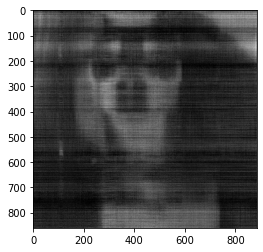

In [589]:
plt.imshow(np.where(D@x<0,0,D@x).T,cmap='gray')

In [592]:
np.linalg.norm(np.where(D@x<0,0,D@x)-y)

55146.7898910187

In [593]:
np.linalg.norm((D@x) - y)

55419.61390542303

In [576]:
np.linalg.norm(abs(D@x) - y)

55021.90815822883

In [587]:
np.linalg.norm(abs(a@x) - y)

55057.72750401087

In [582]:
y.shape

(884, 860)

Distorting image...
Extracting reference patches...
done in 0.03s.
Learning the dictionary...
done in 1.47s.
Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
1 atom...
done in 1.06s.
Orthogonal Matching Pursuit
30 atoms...
done in 32.25s.


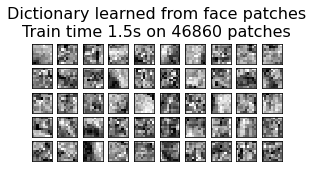

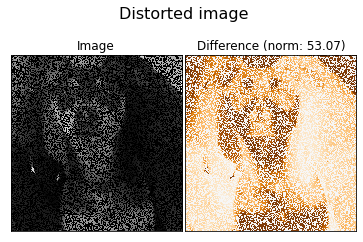

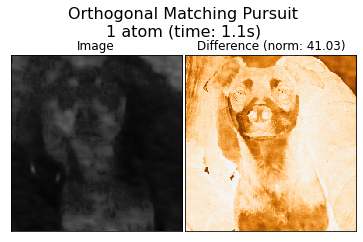

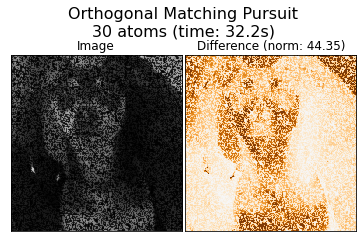

In [607]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import random
from PIL import Image
import imageio


"""
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face

    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)
"""

#face = imageio.imread('original.jpg')
face = arr
# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.0

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the image
print("Distorting image...")
distorted = face.copy()
for _ in range(int(np.floor(height*width*0.75))):
    distorted[random.randint(0, height - 1), random.randint(0, width - 1)] = 0

#trainer = imageio.imread('training_image.jpg')
#trainer = trainer / 255.0
trainer = arr
trainer = trainer[::4, ::4] + trainer[1::4, ::4] + trainer[::4, 1::4] + trainer[1::4, 1::4]
#trainer /= 4.0
trainer = trainer/4

#Extract patches from the training image
print("Extracting reference patches...")
t0 = time()
patch_size = (9, 9)
data = extract_patches_2d(trainer[:, :], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print("done in %.2fs." % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=50, alpha=1, n_iter=250)
V = dico.fit(data).components_
dt = time() - t0
print("done in %.2fs." % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image


def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, face, "Distorted image")

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print("Extracting noisy patches... ")
t0 = time()
#data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = extract_patches_2d(distorted[:, :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

""" transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
] """

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n30 atoms", "omp", {"transform_n_nonzero_coefs": 30})
    ]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    #reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
    #    patches, (height, width // 2)
    #)
    reconstructions[title][:, :] = reconstruct_from_patches_2d(
        patches, (height, width)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], face, title + " (time: %.1fs)" % dt)

plt.show()

In [606]:
trainer/4

array([[39.75, 20.  ,  9.75, ..., 48.25, 51.  ,  0.75],
       [33.75, 17.25, 11.  , ..., 50.5 , 48.25,  4.  ],
       [ 6.25, 14.5 , 14.25, ..., 50.  , 49.25,  4.75],
       ...,
       [38.25, 38.5 , 31.75, ..., 44.75, 41.5 , 50.25],
       [34.25, 36.  , 22.25, ..., 49.5 , 54.  , 55.  ],
       [29.75, 38.5 , 38.5 , ..., 51.25, 52.5 , 49.75]])